In [44]:
from scipy import fft
from scipy import signal as sig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

from scipy import fft
from scipy import signal as sig
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


For this capstone project we will be analyzing some 911 call data from Kaggle. The data contains the following fields:

lat : String variable, Latitude

lng: String variable, Longitude

desc: String variable, Description of the Emergency Call

zip: String variable, Zipcode

title: String variable, Title

timeStamp: String variable, YYYY-MM-DD HH:MM:SS

twp: String variable, Township

addr: String variable, Address

e: String variable, Dummy variable (always 1)

Data preparation
First, let’s import and prep the call data. The raw data is from Kaggle.

In [2]:
#Import numpy and pandas
import numpy as np
import pandas as pd
# Import visualization libraries and set %matplotlib inline.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
df= pd.read_csv('911.csv')

In [4]:
#Check the info() of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        99492 non-null  float64
 1   lng        99492 non-null  float64
 2   desc       99492 non-null  object 
 3   zip        86637 non-null  float64
 4   title      99492 non-null  object 
 5   timeStamp  99492 non-null  object 
 6   twp        99449 non-null  object 
 7   addr       98973 non-null  object 
 8   e          99492 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 6.8+ MB


In [44]:
# Check the head of df
df.head()

,lat,lng,desc,zip,title,timestamp,twp,addr,e,timestamp_trunc,N
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,2015-12-10 17:00:00,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,2015-12-10 17:00:00,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1,2015-12-10 17:00:00,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1,2015-12-10 17:00:00,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,2015-12-10 17:00:00,1


# Prepare Data
For the data prep, let’s transforming the raw data to count the number of calls each hour. We’re aggregating call count at the hour level because call volume at the minute-level is too low and we’re not expecting to see any seasonality below the hour-level. As a rule of thumb, we want our sampling frequency to be twice the highest component frequency the expecting to find in the signal. 

In [34]:

##Make data lowercase
df = df.rename(columns = {k:k.lower() for k in df.columns})
df.head()
df['timestamp'] = pd.to_datetime(df['timestamp'])
# dt. floor() function to floor the datetime data of the given series object to the specified frequency
df['timestamp_trunc'] = df['timestamp'].dt.floor('H')
df['N'] = 1
# Count calls per hour
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]
counts[:3]

,N
timestamp_trunc,
2015-12-10 14:00:00,1
2015-12-10 15:00:00,1
2015-12-10 16:00:00,6


Also, we need to make sure we fill in any missing hours (where there were no 911 calls) with zeros. 

In [35]:

# Create time & signal, filling in missing hours with 0 calls
counts_dict = counts['N'].to_dict()
time = pd.date_range(min(counts.index), max(counts.index), freq = 'H').to_series().sort_values()

# Plotting

Finally, for the signal, let’s chart the difference from the average call count instead of the call count itself. This way, our data is centered around 0, like a real sine wave.
The first week of data is plotted on the right. Definitely seeing some seasonality here, so it looks like our analysis will be promising.

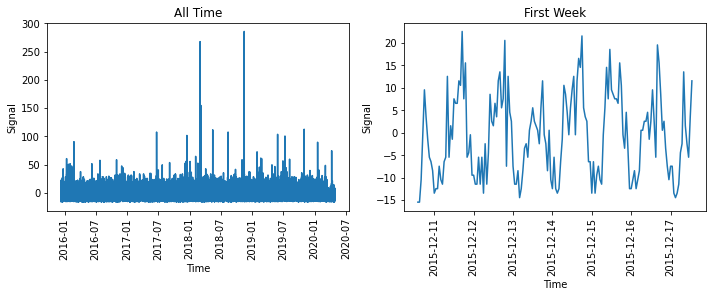

In [16]:
signal = time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)
# print("time \n",time[:1], "\n signal\n",signal[:1])

# Set signal to be the difference of call volume from the average
signal = signal - signal.mean()

## Plot signal in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time, signal, label='signal')
ax1.set_title('All Time')
ax1.set_ylabel( 'Signal' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[:N], signal[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Signal' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

# Fourier Transformation:
## Goal: Find Spikes in Ampitude
We’ll be using the Fourier Transforms submodule in the SciPy package—scipy.fft. We’ll be using the SciPy Fast Fourier Transform (scipy.fft.fft) function to compute the Fourier Transform. Think of the Fast Fourier Transform (FFT) is as the Quicksort of Fourier Transforms. FFT is a more efficient way to compute the Fourier Transform and it’s the standard in most packages.

Just pass the input data into the function and it’ll output the results of the transform. For the amplitude, take the absolute value of the results. To get the corresponding frequency, we use scipy.fft.fftfreq. We can chart the amplitude vs. the frequency. The frequencies with the highest amplitude are indicative of seasonal patterns. Frequencies with low amplitude are noise. Also, scipy’s periodogram function can also get us to a similar chart. We mark the frequencies where we clearly see spikes in amplitude.

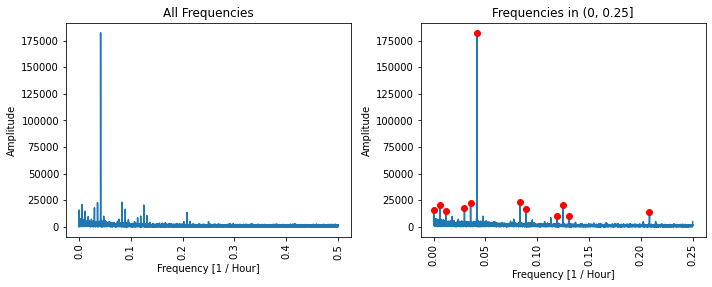

In [38]:
# Plotting power in the frequency domain
fft_output = fft.fft(x=signal.values)
power = np.abs(fft_output)
freq = fft.fftfreq(len(signal))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90);

# Frequencies in  Hour and Days and Power
If we look at those frequencies with the highest amplitudes and convert them into hours and days, we see that the top seasonal pattern has a daily frequency (the period is ~1 day).



In [68]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.reset_index()

,level_0,index,freq (1/hour),amplitude,period (days),fft
0,5,1601,0.041662,182394.732257,1.000104,159960.560353+87638.219327j
1,6,3202,0.083325,23062.588873,0.500052,-13072.116883-19000.072782j
2,4,1372,0.035703,22739.231411,1.167031,13715.245705+18137.383506j
3,1,229,0.005959,20938.466518,6.991994,19667.5580750-7183.7691690j
4,9,4803,0.124987,20551.122807,0.333368,18995.7767450-7842.7746650j
5,3,1144,0.029770,17911.587125,1.399621,10673.835529+14383.816893j
6,7,3431,0.089284,16526.855230,0.466676,11404.119064-11961.731152j
7,2,458,0.011918,14675.705794,3.495997,-13795.7671120+5005.3122120j
8,0,1,0.000026,14321.339760,1601.166667,-10959.9113260+9218.5202850j
9,11,8006,0.208338,13559.538711,0.199996,-4354.712166+012841.2449550j


After that, the amplitude sharply drops off and we see seasonality at 8 hours and 7 days. The former suggests there’s a spike in call volume 3 times a day (potentially morning, evening, and late-night?). The latter suggests that call volume spikes one day out of the week.

The other frequencies are difficult to contextualize, but they’re not very important given their low amplitudes.

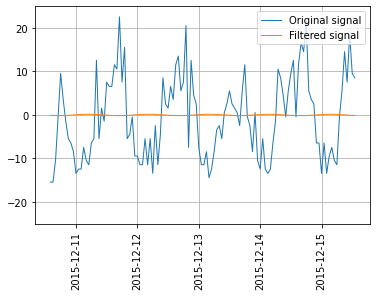

In [32]:
filtered_fft_output = np.array([f if i == 1626 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fft.ifft(filtered_fft_output)

N = 24 * 5
plt.plot(time[:N], signal[:N], linewidth=1, label='Original signal')
plt.plot(time[:N], filtered_sig[:N].real, linewidth=1, label='Filtered signal')
plt.legend(loc='upper right')
ax2.set_title('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

# Results and What can we do?
In the above, we’ve answered our initial questions around what kind of seasonality is in the data, but we haven’t been able to answer when seasonality spikes accurately. To take our analysis to the next level, we need to incorporate seasonality into our regression models.

This will help us figure out when seasonality spikes by trying different inputs inspired by our Fourier results. Additionally, this will allow us to combine seasonality with other variables in our regression model so we can predict future call volume more accurately. We’ll also see how seasonality is often used as a way to explain the residuals in a regression model.

# When seasonality spikes accurately?
 In order to do so, we’ll first run a linear regression and then perform a Fourier transform on the residuals—the errors of the first regression.

What we’re doing is giving our best shot trying to explain the data without using seasonality, and then we’ll use seasonality to explain whatever we can’t explain. 

In [79]:
# Create a new DF with time & signal, filling in missing hours with 0 calls
data = pd.DataFrame()
data['time'] = pd.date_range(min(counts.index), max(counts.index), freq = 'H')
data.set_index('time')
data['time_sec'] = (data.time - min(data.time)).dt.total_seconds()
data['signal'] = data.time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

# time_sec is the hourly timestamp converted to seconds
X = pd.DataFrame(data['time_sec']) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['signal']) 

# Calculating the residuals
The first step is to do the regression. This is from using Sckit-Learn’s LinearRegression model

In [80]:
model = LinearRegression()
model.fit(X, y) 
data['pred_signal_linreg'] = model.predict(X)
data['residuals'] = data['signal'] - data['pred_signal_linreg']

time = data['time']
residuals = data['residuals']

Looking at the model coefficients and intercept, we find a slope of about −3E−10 and intercept of 16.40.

### LinearRegression Interpretation: 
So the call volume starts at ~16.4 calls per hour, and every year the call volume goes down by about −3E−10 × 60 × 60 × 24 × 365 ≈ 0.009 calls per hour.

Our initial hypothesis that we’d see an increase in 911 calls proportional to population growth doesn’t seem to ring true. Also, it’s clear that this regression isn’t very helpful. 

In [82]:
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

Slope: 2.64e-09, Intercept: 16.26
R-squared: 1.01e-04


## Low R Square:
The R² above is really pitiful. The low R-squared reveals poor fit on time alone. This suggests that we can improve R-squared (fitting) significantly by incorporating our Fourier terms.

# Fourier transform of Residuals
As we said above, we’ll use the Fourier transform to find the most dominant frequencies. Here are the dominant frequencies we find after the Fourier transform.

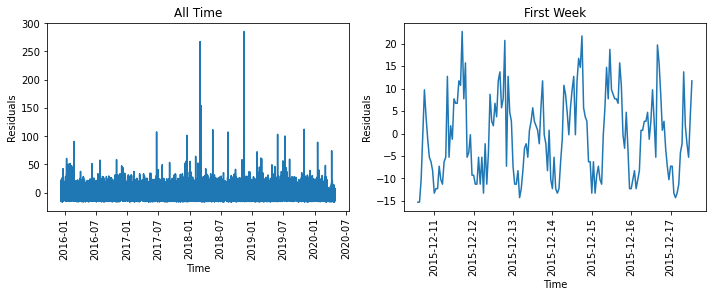

In [84]:
## Plot residuals in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time, residuals, label='residuals')
ax1.set_title('All Time')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[:N], residuals[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

#  Find the Dominant Frequencies of Residuals

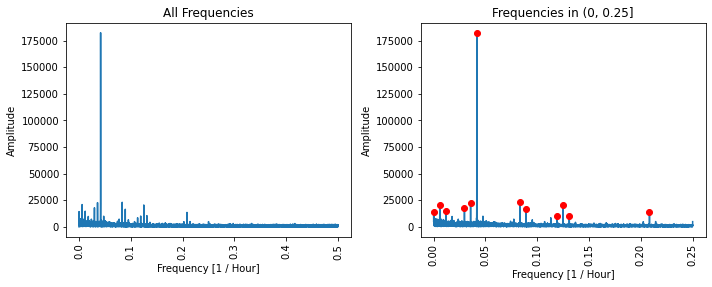

In [50]:
# Plotting power in the frequency domain
fft_output = fft.fft(residuals.values)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90);

Here are the values these peaks correspond to (not very different from what we saw in plotting signals in the above). 


In [51]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq (1/hour),amplitude,period (days),fft
5,1601,0.041662,182394.732257,1.000104,159960.560353+87638.219327j
6,3202,0.083325,23062.588873,0.500052,-13072.116883-19000.072782j
4,1372,0.035703,22739.231411,1.167031,13715.245705+18137.383506j
1,229,0.005959,20938.466518,6.991994,19667.5580750-7183.7691690j
9,4803,0.124987,20551.122807,0.333368,18995.7767450-7842.7746650j
3,1144,0.029770,17911.587125,1.399621,10673.835529+14383.816893j
7,3431,0.089284,16526.855230,0.466676,11404.119064-11961.731152j
2,458,0.011918,14675.705794,3.495997,-13795.7671120+5005.3122120j
0,1,0.000026,14321.339760,1601.166667,-10959.9113260+9218.5202850j
11,8006,0.208338,13559.538711,0.199996,-4354.712166+012841.2449550j


I labeled indexes with FT_1 ... FT_12 for easy reference.

The FFT column is what’s output by running scipy.fft.fft(residuals) plotted above. We can get the frequencies by running fft.fftfreq(len(residuals)) . These frequencies will have the unit of 1 / timestep, where the timestep is the spacing between our residuals (in our case, this is an hour) The amplitude is abs(fft) and the phase is cmath.phase(fft) .

In [53]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,159960.560353+87638.219327j,0.041662,182394.732257,0.501209
FT_2,-13072.116883-19000.072782j,0.083325,23062.588873,-2.173426
FT_3,13715.245705+18137.383506j,0.035703,22739.231411,0.923348
FT_4,19667.5580750-7183.7691690j,0.005959,20938.466518,-0.350204
FT_5,18995.7767450-7842.7746650j,0.124987,20551.122807,-0.391551
FT_6,10673.835529+14383.816893j,0.029770,17911.587125,0.932388
FT_7,11404.119064-11961.731152j,0.089284,16526.855230,-0.809258
FT_8,-13795.7671120+5005.3122120j,0.011918,14675.705794,2.793547
FT_9,-10959.9113260+9218.5202850j,0.000026,14321.339760,2.442281


In the above, each of these rows, corresponds to a sinusoid (a curve having the form of a sine wave). We can use the inverse Fourier transform to calculate these sinusoid and plot their sum versus the original residuals. 

# Inverse Fourier Transform
We use this to calculate these sinusoid and plot their sum versus the original residuals

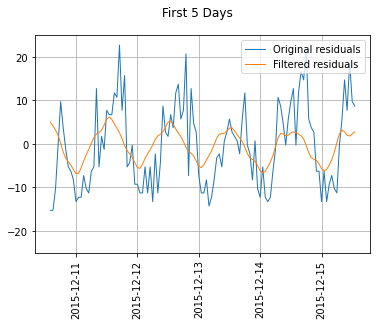

In [85]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 24 * 5
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

Compared to the last signal plot, these Inverse Fourier Transform of residuals and original residual data fit pretty well.

# Incorporating into our regression
Now lets incorporate our sinusoids into our initial regression. The problem with these sinusoids is that the amplitude is off. You can see in the chart above that it appears too low. This is because we did the Fourier transform on the resiudals and filtered the output down to just 12 terms. So our filtering

Our initial regression just used time as its only variable, but now we can add our Fourier terms. The phase, amplitude, and frequency let us plot the wave that the FFT term corresponds to, using this formula.

<img src="equation.png">

What we’re trying to do now is figure out what the new regression would be if we added several new variables related to these waves from the FFT.

So we go back to our original data, that had the time in seconds and the number of calls for that time, and we add several columns corresponding to each of the waves from our Fourier transform. Then we can sum these together into a new column, FT_All that is as follows. 
This gives us a new variable, FT_All , which is the same as the “Filtered Residuals” we charted earlier.

In [54]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 3600)
    p = fourier_terms_dict[key]['phase']
    data[key] = data['time_sec'].apply(lambda t: a * math.cos(w*t + p))

data['FT_All'] = 0
for column in list(fourier_terms.index):
    data['FT_All'] = data['FT_All'] + data[column]


# Sample 
data[['signal', 'time_sec', 'FT_All']  + list(fourier_terms.index)]

,signal,time_sec,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,FT_9,FT_10,FT_11,FT_12
0,1,0.0,192334.339198,159960.560353,-13072.116883,13715.245705,19667.558075,18995.776745,10673.835529,11404.119064,-13795.767112,-10959.911326,-4354.712166,10068.676389,-9968.925175
1,1,3600.0,159349.882849,131831.031197,-1822.001937,9336.881269,19922.690259,18978.366368,7812.818722,16020.120818,-14131.577934,-10961.418458,-13530.748527,4525.644383,-8631.923308
2,6,7200.0,122928.877454,94719.294653,9916.217658,4490.617751,20149.894922,7845.880472,4679.244907,15725.327960,-14388.178245,-10962.925296,-2648.606336,-3911.978231,-2685.912762
3,16,10800.0,75508.900409,51153.930762,18997.935167,-580.684069,20348.853571,-7881.708725,1382.431547,10610.106051,-14564.129743,-10964.431841,12159.868437,-9847.509543,4694.238796
4,26,14400.0,6677.790604,4103.232571,22990.206662,-5622.886073,20519.287305,-18993.211058,-1962.609146,2242.470991,-14658.446184,-10965.938093,8942.377256,-9484.598860,9567.905232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38423,12,138322800.0,139472.021274,126070.819835,1814.483697,22293.610882,17986.842466,-7894.120142,17911.513730,-14715.306559,-11009.316956,-10952.371276,-880.926553,-8291.650218,7138.442368
38424,22,138326400.0,132982.587795,155887.527348,-9923.026115,22731.528266,18375.483316,-18998.340402,17608.619673,-16462.341802,-11704.485904,-10953.879872,-13297.911565,-10428.303447,10147.718298
38425,20,138330000.0,153954.306696,175082.956342,-19002.209890,22030.300695,18738.365510,-18975.786935,16691.433537,-13163.024377,-12334.048708,-10955.388175,-6001.878926,-5895.040381,7738.628004
38426,11,138333600.0,190128.279176,182349.240812,-22990.802476,20225.068782,19074.980365,-7839.668648,15191.952160,-5828.724327,-12894.476535,-10956.896185,10191.426388,2408.675482,1197.503358


These Fourier terms may seem daunting, but basically, they are just sinusoids (i.e. waves) that we identified are important in our Fourier transform. They were important because they peaked in the frequency domain. If we plot FT_1 we see it’s a wave with a one-day period and a specific phase shift, which matches the daily seasonality we see in the data.

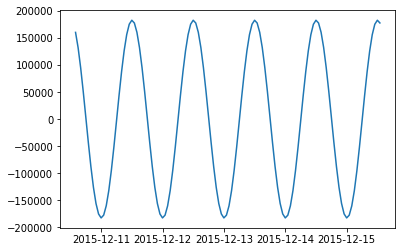

In [55]:
# Check the first Fourier term, which should have a period = 1 day
plt.plot(data['time'][:24*5], data['FT_1'][:24*5])

# Run a Regression Using our New Variable:
Here’s how the regression results look for the first 5 days. It definitely looks promising.

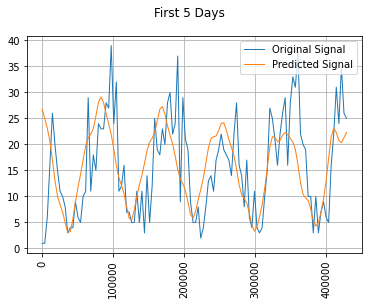

In [65]:
# time_sec is the hourly timestamp converted to seconds
# list(fourier_terms.index) are the names of our Fourier terms
# X = pd.DataFrame(data[['time_sec'] + list(fourier_terms.index)]) 
X = pd.DataFrame(data[['time_sec', 'FT_All']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)


N = 24 * 5

plt.plot(X['time_sec'][:N], y[:N].values, linewidth=1, label='Original Signal')
plt.plot(X['time_sec'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.xticks(rotation=90)

print()

## Check R-Squared:

In [66]:
model.score(X,y)

0.45064174869706564

That’s an R² improvement from 0.000001 to 0.41 from just adding one new variable. Not bad at all!

# Why are Fourier transforms helpful in regressions?
Fourier transforms aren’t the only way to analyze seasonality in a regression. We would definitely consider exploring other simpler options, like adding a dummy variable for an hour of the day or day of week, especially if we already have a strong intuition for what to expect.

For example, say we know that 911 call volumes spike between 6 and 9 pm, then we can just create a new variable that’s 1 when the time is between 6 and 9 pm, and 0 otherwise. The coefficient will tell us pretty clearly how much more call volume to expect during evening hours.

The challenge is knowing how to even start. Is it 6 to 9 pm, or 7 to 10 pm? Or do weekends impact call volume more than evenings do? The Fourier transform is a great way to answer those questions. It gives ua a quantifiable way to measure seasonality in our data. Then if we want to leverage it in your regression, we have an easy option to do so by incorporating the sinusoids that the Fourier transform outputs. Or we can take the insights from the Fourier analysis, and test simpler variables in our regression.